PCA code copied and adapted from: "Reducing dimensionality with principal component analysis with Python
Optimize the classification of a data set by applying PCA with Python" By Eda Kavlakoglu (https://developer.ibm.com/tutorials/awb-reducing-dimensionality-with-principal-component-analysis/)

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import os
import pickle
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import CMGDB
import matplotlib

In [2]:
num_init_cond = 100

# Load data

# train_file = 'data/Leslie/19.6_23.68_23.68/train.csv'
# test_file = 'data/Leslie/19.6_23.68_23.68/test.csv'

train_file = 'data/Leslie/28.9_29.8_22.0/train.csv'
test_file = 'data/Leslie/28.9_29.8_22.0/test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

X_train = train_df[['x0', 'x1', 'x2']]
Y_train = train_df[['y0', 'y1', 'y2']]

last_100 = Y_train.tail(num_init_cond)
last_100.columns = ['x0', 'x1', 'x2']

all_dynamics = pd.concat([X_train, last_100], axis = 0, ignore_index=True)

print(all_dynamics)

X_test = test_df[['x0', 'x1', 'x2']]
Y_test = test_df[['y0', 'y1', 'y2']]

              x0         x1         x2
0      12.237603  43.710714  24.998750
1      10.473147  51.040892  61.578118
2      57.146602  36.074413  50.270416
3      73.482894  47.333555  35.814083
4       5.339335  16.423745  22.306953
...          ...        ...        ...
8095    1.263991   0.048545  49.961218
8096    6.745537   0.884794   0.033982
8097  103.184483   4.721876   0.619355
8098    0.060704  72.229138   3.305313
8099    1.160499   0.042493  50.560397

[8100 rows x 3 columns]


In [3]:
# Scale and center the data (mean zero, sd 1)

sc = StandardScaler()
all_dynamics_scaled = sc.fit_transform(all_dynamics)

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Y_train_scaled = sc.fit_transform(Y_train)
Y_test_scaled = sc.transform(Y_test)

all dynamics_scaled shape: (8100, 3)
Number of features: 3
X_train_scaled.T shape: (3, 8000)
cov_mat shape: (3, 3)
[[ 1.00012502 -0.30934803 -0.29217903]
 [-0.30934803  1.00012502 -0.28722114]
 [-0.29217903 -0.28722114  1.00012502]]


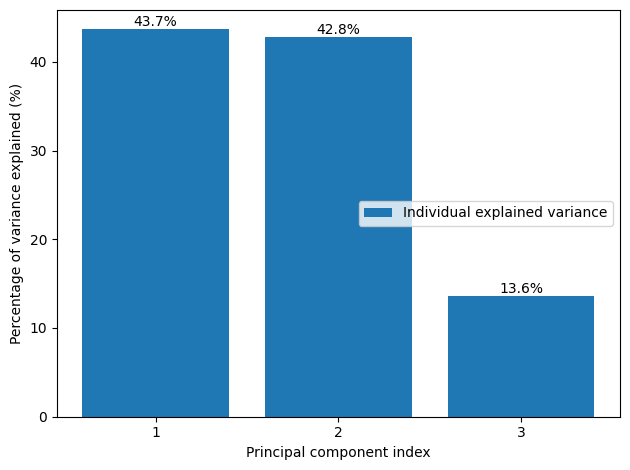

In [4]:
num_features = all_dynamics_scaled.shape[1]

print('all dynamics_scaled shape:', all_dynamics_scaled.shape)
print(f'Number of features: {num_features}')

print('X_train_scaled.T shape:', X_train_scaled.T.shape)

# covariance matrix, eigenvalues and eigenvectors
cov_mat = np.cov(X_train_scaled.T)

print('cov_mat shape:', cov_mat.shape)
print(cov_mat)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# sort eigenvalues in descending order
eigen_vals = np.sort(eigen_vals)[::-1]

# explained variance percentages
exp_var = [(i / np.sum(eigen_vals)) * 100 for i in eigen_vals]

# plot
bar = plt.bar(range(1, len(exp_var) + 1), exp_var, align='center',
              label='Individual explained variance')

# add % labels on bars
for i, bar in enumerate(bar):
    plt.text(bar.get_x() + bar.get_width() / (num_features - 1), bar.get_height(),
             f'{exp_var[i]:.1f}%', ha='center', va='bottom')

plt.ylabel('Percentage of variance explained (%)')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, len(exp_var) + 1)))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Scree Plot')

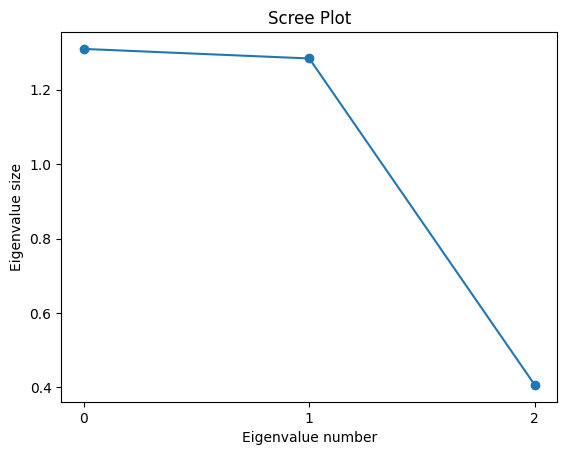

In [5]:
# generate scree plot
pca = PCA()
all_dynamics_scaled_transformed = pca.fit_transform(all_dynamics_scaled)
explained_variance = pca.explained_variance_ratio_
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
x_ticks = list(range(0, len(explained_variance)))
plt.xticks(ticks=x_ticks)
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [6]:
pca_2 = PCA(n_components=2)
pca_2.fit(all_dynamics_scaled)

X_train_pca = pca_2.transform(X_train_scaled)
Y_train_pca = pca_2.transform(Y_train_scaled)

pca_df_X_train = pd.DataFrame(data=X_train_pca, columns=['principal component 1', 'principal component 2'])
pca_df_Y_train = pd.DataFrame(data=Y_train_pca, columns=['principal component 1', 'principal component 2'])

X_test_pca = pca_2.transform(X_test_scaled)
Y_test_pca = pca_2.transform(Y_test_scaled)

pca_df_X_test = pd.DataFrame(data=X_test_pca, columns=['principal component 1', 'principal component 2'])
pca_df_Y_test = pd.DataFrame(data=Y_test_pca, columns=['principal component 1', 'principal component 2'])

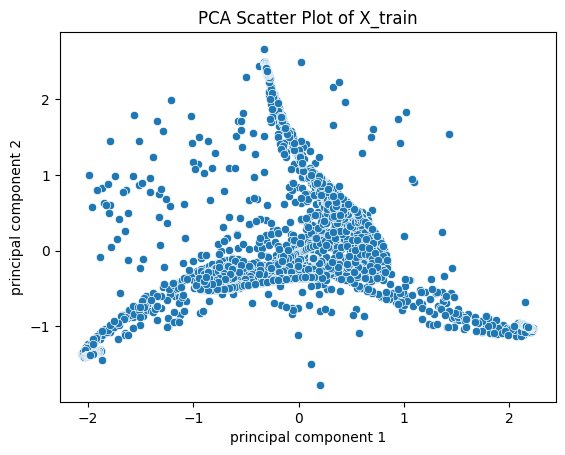

PC1 min: -2.0528651866744636, PC1 max: 2.2251934027628932
PC2 min: -1.7719424884493586, PC2 max: 2.663360433939169


In [7]:
ax = sns.scatterplot(
    x=pca_df_X_train.iloc[:,0], 
    y=pca_df_X_train.iloc[:,1],
    data=pca_df_X_train,
    legend=True
)

# Add a title
ax.set_title("PCA Scatter Plot of X_train")

plt.show()

# get min and max values for each principal component
pc1_min, pc1_max = pca_df_X_train['principal component 1'].min(), pca_df_X_train['principal component 1'].max()
pc2_min, pc2_max = pca_df_X_train['principal component 2'].min(), pca_df_X_train['principal component 2'].max()

print(f'PC1 min: {pc1_min}, PC1 max: {pc1_max}')
print(f'PC2 min: {pc2_min}, PC2 max: {pc2_max}')

In [8]:
# scale targets to lie in [-1, 1] x [-1, 1]
# Convert to numpy
y_train = pca_df_Y_train.values
y_test = pca_df_Y_test.values

# Get min/max from training set only
y_min = y_train.min(axis=0)
y_max = y_train.max(axis=0)

# Scale function
def scale_to_unit_interval(y, y_min, y_max):
    return 2 * (y - y_min) / (y_max - y_min + 1e-8) - 1

# Apply scaling
y_train_scaled = scale_to_unit_interval(y_train, y_min, y_max)
y_test_scaled = scale_to_unit_interval(y_test, y_min, y_max)

# Replace in your DataFrames
pca_df_Y_train = pd.DataFrame(y_train_scaled, columns=pca_df_Y_train.columns)
pca_df_Y_test = pd.DataFrame(y_test_scaled, columns=pca_df_Y_test.columns)

### Latent dynamics model training

#### Load data

In [9]:
X_train_tensor = torch.tensor(pca_df_X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(pca_df_Y_train.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

X_test_tensor = torch.tensor(pca_df_X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(pca_df_Y_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#### Define latent dynamics model

In [10]:
class LatentDynamics(nn.Module):
    def __init__(self, num_layers=3, hidden_shape=32, lower_shape=2):
        super(LatentDynamics, self).__init__()

        self.dynamics = nn.Sequential()
        for i in range(num_layers):
            if i == 0:
                self.dynamics.add_module(f"linear_{i}", nn.Linear(lower_shape, hidden_shape))
            else:
                self.dynamics.add_module(f"linear_{i}", nn.Linear(hidden_shape, hidden_shape))
            self.dynamics.add_module(f"relu_{i}", nn.ReLU(True))
        self.dynamics.add_module(f"linear_{num_layers}", nn.Linear(hidden_shape, lower_shape))
      #  self.dynamics.add_module(f"tanh_{num_layers}", nn.Tanh())
    
    def forward(self, x):
        x = self.dynamics(x)
        return x

#### Define training class and train loop

In [11]:
class Training:
    def __init__(self, train_loader, test_loader, lr=0.001, model_dir='output/Leslie/models', log_dir='output/Leslie/logs', verbose=True):
        self.dynamics = LatentDynamics()
        self.train_loader = train_loader
        self.test_loader = test_loader

        self.lr = lr

        self.model_dir = model_dir
        self.log_dir = log_dir

        self.verbose = bool(verbose)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device: ", self.device)

        self.dynamics.to(self.device)

        self.reset_losses()

        self.dynamics_criterion = nn.MSELoss(reduction='mean')

    def save_models(self, subfolder='', suffix=''):
        save_path = os.path.join(self.model_dir, subfolder)
        os.makedirs(save_path, exist_ok=True)
        torch.save(self.dynamics, os.path.join(save_path, 'dynamics' + suffix + '.pt'))
    
    def load_models(self):
        self.dynamics = torch.load(os.path.join(self.model_dir, 'dynamics_.pt'))
    
    def save_logs(self, suffix=''):
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        
        with open(os.path.join(self.log_dir, 'train_losses_' + suffix + '.pkl'), 'wb') as f:
            pickle.dump(self.train_losses, f)
        
        with open(os.path.join(self.log_dir, 'test_losses_' + suffix + '.pkl'), 'wb') as f:
            pickle.dump(self.test_losses, f)
    
    def reset_losses(self):
        self.train_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_contrastive': [], 'loss_topo': [], 'loss_total': []}
        self.test_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_contrastive': [], 'loss_topo': [], 'loss_total': []}
    
    def forward(self, z_t, z_tau):
        # z_t = E(x_t)
        # z_tau = E(x_tau)

        # z_tau_pred = latent_dynamics(E(x_t))
        z_tau_pred = self.dynamics(z_t)

        return (z_tau, z_tau_pred)

    def dynamics_losses(self, forward_pass):
        z_tau, z_tau_pred = forward_pass
        loss_dyn = self.dynamics_criterion(z_tau_pred, z_tau)
        return loss_dyn
    
    def train(self, epochs=1000, patience=100):

        list_parameters = list(self.dynamics.parameters())
        optimizer = torch.optim.Adam(list_parameters, lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=patience)
        for epoch in tqdm(range(epochs)):

            epoch_train_loss = 0
            epoch_test_loss  = 0

            self.dynamics.train()

            num_batches = len(self.train_loader)
            for (x_t, x_tau) in self.train_loader:
                x_t = x_t.to(self.device)
                x_tau = x_tau.to(self.device)
                optimizer.zero_grad()

                # Forward pass (apply all models)
                forward_pass = self.forward(x_t, x_tau)
                # Compute losses
                loss_dyn = self.dynamics_losses(forward_pass)

                # Backward pass
                loss_dyn.backward()
                optimizer.step()

                epoch_train_loss += loss_dyn.item()

            epoch_train_loss /= num_batches

            self.train_losses['loss_total'].append(epoch_train_loss)

            self.dynamics.eval()
            with torch.no_grad():

                num_batches = len(self.test_loader)
                for (x_t, x_tau) in self.test_loader:
                    optimizer.zero_grad()

                    # Forward pass (apply all models)
                    forward_pass = self.forward(x_t, x_tau)
                    # Compute losses
                    loss_dyn = self.dynamics_losses(forward_pass)

                    epoch_test_loss += loss_dyn.item()

                epoch_test_loss /= num_batches

                self.test_losses['loss_total'].append(epoch_test_loss)

            scheduler.step(epoch_test_loss)
            
            if epoch >= patience:
                if np.mean(self.test_losses['loss_total'][-patience:]) > np.mean(self.test_losses['loss_total'][-patience-1:-1]):
                    if self.verbose:
                        print("Early stopping")
                    break
            
            if self.verbose:
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch + 1, epochs, epoch_train_loss, epoch_test_loss))

#### Train latent dynamics model

In [12]:
trainer = Training(train_loader=train_loader, test_loader=test_loader)
trainer.train()
trainer.save_logs()
trainer.reset_losses()
trainer.save_models()

Device:  cpu


  0%|          | 2/1000 [00:00<05:17,  3.14it/s]

Epoch [1/1000], Train Loss: 0.3235, Test Loss: 0.2853
Epoch [2/1000], Train Loss: 0.3139, Test Loss: 0.2830


  0%|          | 3/1000 [00:00<03:59,  4.17it/s]

Epoch [3/1000], Train Loss: 0.3122, Test Loss: 0.2802


  0%|          | 4/1000 [00:01<04:14,  3.91it/s]

Epoch [4/1000], Train Loss: 0.3121, Test Loss: 0.2789


  0%|          | 5/1000 [00:01<04:50,  3.43it/s]

Epoch [5/1000], Train Loss: 0.3110, Test Loss: 0.2787


  1%|          | 7/1000 [00:01<04:02,  4.10it/s]

Epoch [6/1000], Train Loss: 0.3111, Test Loss: 0.2786
Epoch [7/1000], Train Loss: 0.3111, Test Loss: 0.2786


  1%|          | 9/1000 [00:02<03:21,  4.91it/s]

Epoch [8/1000], Train Loss: 0.3104, Test Loss: 0.2783
Epoch [9/1000], Train Loss: 0.3110, Test Loss: 0.2781


  1%|          | 11/1000 [00:02<03:06,  5.30it/s]

Epoch [10/1000], Train Loss: 0.3107, Test Loss: 0.2780
Epoch [11/1000], Train Loss: 0.3107, Test Loss: 0.2783


  1%|▏         | 13/1000 [00:02<02:53,  5.68it/s]

Epoch [12/1000], Train Loss: 0.3106, Test Loss: 0.2779
Epoch [13/1000], Train Loss: 0.3105, Test Loss: 0.2782


  2%|▏         | 15/1000 [00:03<02:42,  6.06it/s]

Epoch [14/1000], Train Loss: 0.3103, Test Loss: 0.2778
Epoch [15/1000], Train Loss: 0.3100, Test Loss: 0.2776


  2%|▏         | 17/1000 [00:03<03:02,  5.37it/s]

Epoch [16/1000], Train Loss: 0.3110, Test Loss: 0.2782
Epoch [17/1000], Train Loss: 0.3106, Test Loss: 0.2779


  2%|▏         | 19/1000 [00:03<02:48,  5.82it/s]

Epoch [18/1000], Train Loss: 0.3106, Test Loss: 0.2782
Epoch [19/1000], Train Loss: 0.3104, Test Loss: 0.2781


  2%|▏         | 21/1000 [00:04<02:39,  6.13it/s]

Epoch [20/1000], Train Loss: 0.3104, Test Loss: 0.2775
Epoch [21/1000], Train Loss: 0.3109, Test Loss: 0.2778


  2%|▏         | 23/1000 [00:04<02:38,  6.15it/s]

Epoch [22/1000], Train Loss: 0.3109, Test Loss: 0.2780
Epoch [23/1000], Train Loss: 0.3108, Test Loss: 0.2780


  2%|▎         | 25/1000 [00:04<02:41,  6.03it/s]

Epoch [24/1000], Train Loss: 0.3101, Test Loss: 0.2783
Epoch [25/1000], Train Loss: 0.3104, Test Loss: 0.2778


  3%|▎         | 27/1000 [00:05<02:55,  5.54it/s]

Epoch [26/1000], Train Loss: 0.3104, Test Loss: 0.2777
Epoch [27/1000], Train Loss: 0.3109, Test Loss: 0.2776


  3%|▎         | 29/1000 [00:05<02:38,  6.14it/s]

Epoch [28/1000], Train Loss: 0.3104, Test Loss: 0.2776
Epoch [29/1000], Train Loss: 0.3106, Test Loss: 0.2775


  3%|▎         | 31/1000 [00:05<02:28,  6.53it/s]

Epoch [30/1000], Train Loss: 0.3105, Test Loss: 0.2778
Epoch [31/1000], Train Loss: 0.3107, Test Loss: 0.2784


  3%|▎         | 33/1000 [00:06<02:24,  6.68it/s]

Epoch [32/1000], Train Loss: 0.3103, Test Loss: 0.2779
Epoch [33/1000], Train Loss: 0.3107, Test Loss: 0.2769


  4%|▎         | 35/1000 [00:06<02:21,  6.80it/s]

Epoch [34/1000], Train Loss: 0.3102, Test Loss: 0.2778
Epoch [35/1000], Train Loss: 0.3106, Test Loss: 0.2777


  4%|▎         | 36/1000 [00:06<02:21,  6.83it/s]

Epoch [36/1000], Train Loss: 0.3107, Test Loss: 0.2783


  4%|▍         | 38/1000 [00:07<02:42,  5.90it/s]

Epoch [37/1000], Train Loss: 0.3104, Test Loss: 0.2773
Epoch [38/1000], Train Loss: 0.3105, Test Loss: 0.2778


  4%|▍         | 40/1000 [00:07<02:33,  6.25it/s]

Epoch [39/1000], Train Loss: 0.3105, Test Loss: 0.2776
Epoch [40/1000], Train Loss: 0.3107, Test Loss: 0.2774


  4%|▍         | 42/1000 [00:07<02:31,  6.33it/s]

Epoch [41/1000], Train Loss: 0.3108, Test Loss: 0.2782
Epoch [42/1000], Train Loss: 0.3105, Test Loss: 0.2780


  4%|▍         | 44/1000 [00:07<02:26,  6.54it/s]

Epoch [43/1000], Train Loss: 0.3102, Test Loss: 0.2776
Epoch [44/1000], Train Loss: 0.3103, Test Loss: 0.2775


  5%|▍         | 46/1000 [00:08<02:21,  6.73it/s]

Epoch [45/1000], Train Loss: 0.3102, Test Loss: 0.2777
Epoch [46/1000], Train Loss: 0.3105, Test Loss: 0.2773


  5%|▍         | 48/1000 [00:08<02:43,  5.81it/s]

Epoch [47/1000], Train Loss: 0.3104, Test Loss: 0.2776
Epoch [48/1000], Train Loss: 0.3099, Test Loss: 0.2779


  5%|▌         | 50/1000 [00:09<02:43,  5.80it/s]

Epoch [49/1000], Train Loss: 0.3104, Test Loss: 0.2777
Epoch [50/1000], Train Loss: 0.3108, Test Loss: 0.2770


  5%|▌         | 52/1000 [00:09<02:34,  6.15it/s]

Epoch [51/1000], Train Loss: 0.3102, Test Loss: 0.2774
Epoch [52/1000], Train Loss: 0.3104, Test Loss: 0.2780


  5%|▌         | 54/1000 [00:09<02:32,  6.19it/s]

Epoch [53/1000], Train Loss: 0.3103, Test Loss: 0.2772
Epoch [54/1000], Train Loss: 0.3104, Test Loss: 0.2777


  6%|▌         | 56/1000 [00:09<02:25,  6.48it/s]

Epoch [55/1000], Train Loss: 0.3108, Test Loss: 0.2779
Epoch [56/1000], Train Loss: 0.3103, Test Loss: 0.2780


  6%|▌         | 57/1000 [00:10<02:23,  6.59it/s]

Epoch [57/1000], Train Loss: 0.3105, Test Loss: 0.2775


  6%|▌         | 59/1000 [00:10<02:42,  5.79it/s]

Epoch [58/1000], Train Loss: 0.3103, Test Loss: 0.2770
Epoch [59/1000], Train Loss: 0.3104, Test Loss: 0.2780


  6%|▌         | 61/1000 [00:10<02:28,  6.34it/s]

Epoch [60/1000], Train Loss: 0.3102, Test Loss: 0.2773
Epoch [61/1000], Train Loss: 0.3108, Test Loss: 0.2776


  6%|▋         | 63/1000 [00:11<02:28,  6.29it/s]

Epoch [62/1000], Train Loss: 0.3101, Test Loss: 0.2773
Epoch [63/1000], Train Loss: 0.3103, Test Loss: 0.2778


  6%|▋         | 65/1000 [00:11<02:23,  6.50it/s]

Epoch [64/1000], Train Loss: 0.3105, Test Loss: 0.2775
Epoch [65/1000], Train Loss: 0.3106, Test Loss: 0.2776


  7%|▋         | 67/1000 [00:11<02:24,  6.45it/s]

Epoch [66/1000], Train Loss: 0.3105, Test Loss: 0.2774
Epoch [67/1000], Train Loss: 0.3104, Test Loss: 0.2781


  7%|▋         | 68/1000 [00:11<02:49,  5.51it/s]

Epoch [68/1000], Train Loss: 0.3105, Test Loss: 0.2773


  7%|▋         | 70/1000 [00:12<03:22,  4.59it/s]

Epoch [69/1000], Train Loss: 0.3105, Test Loss: 0.2775
Epoch [70/1000], Train Loss: 0.3102, Test Loss: 0.2775


  7%|▋         | 72/1000 [00:12<02:59,  5.17it/s]

Epoch [71/1000], Train Loss: 0.3102, Test Loss: 0.2775
Epoch [72/1000], Train Loss: 0.3106, Test Loss: 0.2774


  7%|▋         | 74/1000 [00:13<02:36,  5.91it/s]

Epoch [73/1000], Train Loss: 0.3099, Test Loss: 0.2777
Epoch [74/1000], Train Loss: 0.3106, Test Loss: 0.2773


  8%|▊         | 76/1000 [00:13<02:24,  6.41it/s]

Epoch [75/1000], Train Loss: 0.3106, Test Loss: 0.2771
Epoch [76/1000], Train Loss: 0.3102, Test Loss: 0.2775


  8%|▊         | 78/1000 [00:13<02:18,  6.67it/s]

Epoch [77/1000], Train Loss: 0.3104, Test Loss: 0.2777
Epoch [78/1000], Train Loss: 0.3105, Test Loss: 0.2775


  8%|▊         | 80/1000 [00:14<02:35,  5.90it/s]

Epoch [79/1000], Train Loss: 0.3107, Test Loss: 0.2773
Epoch [80/1000], Train Loss: 0.3102, Test Loss: 0.2774


  8%|▊         | 82/1000 [00:14<02:33,  5.98it/s]

Epoch [81/1000], Train Loss: 0.3100, Test Loss: 0.2772
Epoch [82/1000], Train Loss: 0.3101, Test Loss: 0.2773


  8%|▊         | 84/1000 [00:14<02:23,  6.40it/s]

Epoch [83/1000], Train Loss: 0.3099, Test Loss: 0.2776
Epoch [84/1000], Train Loss: 0.3103, Test Loss: 0.2776


  9%|▊         | 86/1000 [00:15<02:35,  5.89it/s]

Epoch [85/1000], Train Loss: 0.3105, Test Loss: 0.2775
Epoch [86/1000], Train Loss: 0.3100, Test Loss: 0.2776


  9%|▉         | 88/1000 [00:15<02:22,  6.41it/s]

Epoch [87/1000], Train Loss: 0.3105, Test Loss: 0.2772
Epoch [88/1000], Train Loss: 0.3108, Test Loss: 0.2771


  9%|▉         | 89/1000 [00:15<02:18,  6.58it/s]

Epoch [89/1000], Train Loss: 0.3102, Test Loss: 0.2773


  9%|▉         | 91/1000 [00:15<02:37,  5.78it/s]

Epoch [90/1000], Train Loss: 0.3106, Test Loss: 0.2780
Epoch [91/1000], Train Loss: 0.3104, Test Loss: 0.2774


  9%|▉         | 93/1000 [00:16<02:41,  5.62it/s]

Epoch [92/1000], Train Loss: 0.3104, Test Loss: 0.2774
Epoch [93/1000], Train Loss: 0.3108, Test Loss: 0.2768


  9%|▉         | 94/1000 [00:16<02:43,  5.56it/s]

Epoch [94/1000], Train Loss: 0.3103, Test Loss: 0.2772


 10%|▉         | 95/1000 [00:16<02:48,  5.36it/s]

Epoch [95/1000], Train Loss: 0.3105, Test Loss: 0.2774


 10%|▉         | 97/1000 [00:17<02:55,  5.16it/s]

Epoch [96/1000], Train Loss: 0.3102, Test Loss: 0.2778
Epoch [97/1000], Train Loss: 0.3104, Test Loss: 0.2775


 10%|▉         | 99/1000 [00:17<02:38,  5.69it/s]

Epoch [98/1000], Train Loss: 0.3099, Test Loss: 0.2775
Epoch [99/1000], Train Loss: 0.3103, Test Loss: 0.2775


 10%|█         | 101/1000 [00:17<02:49,  5.30it/s]

Epoch [100/1000], Train Loss: 0.3103, Test Loss: 0.2772
Epoch [101/1000], Train Loss: 0.3107, Test Loss: 0.2766


 10%|█         | 103/1000 [00:18<02:37,  5.69it/s]

Epoch [102/1000], Train Loss: 0.3102, Test Loss: 0.2776
Epoch [103/1000], Train Loss: 0.3105, Test Loss: 0.2780


 10%|█         | 105/1000 [00:18<02:40,  5.57it/s]

Epoch [104/1000], Train Loss: 0.3100, Test Loss: 0.2776
Epoch [105/1000], Train Loss: 0.3109, Test Loss: 0.2772


 11%|█         | 107/1000 [00:18<02:42,  5.49it/s]

Epoch [106/1000], Train Loss: 0.3101, Test Loss: 0.2773
Epoch [107/1000], Train Loss: 0.3103, Test Loss: 0.2771


 11%|█         | 109/1000 [00:19<02:52,  5.17it/s]

Epoch [108/1000], Train Loss: 0.3103, Test Loss: 0.2773
Epoch [109/1000], Train Loss: 0.3101, Test Loss: 0.2778


 11%|█         | 110/1000 [00:19<02:48,  5.29it/s]

Epoch [110/1000], Train Loss: 0.3103, Test Loss: 0.2772


 11%|█         | 111/1000 [00:19<03:07,  4.74it/s]

Epoch [111/1000], Train Loss: 0.3107, Test Loss: 0.2770


 11%|█▏        | 113/1000 [00:20<02:59,  4.93it/s]

Epoch [112/1000], Train Loss: 0.3099, Test Loss: 0.2767
Epoch [113/1000], Train Loss: 0.3104, Test Loss: 0.2774


 12%|█▏        | 115/1000 [00:20<02:51,  5.16it/s]

Epoch [114/1000], Train Loss: 0.3102, Test Loss: 0.2774
Epoch [115/1000], Train Loss: 0.3103, Test Loss: 0.2773


 12%|█▏        | 117/1000 [00:20<02:37,  5.60it/s]

Epoch [116/1000], Train Loss: 0.3103, Test Loss: 0.2776
Epoch [117/1000], Train Loss: 0.3101, Test Loss: 0.2772


 12%|█▏        | 119/1000 [00:21<02:39,  5.52it/s]

Epoch [118/1000], Train Loss: 0.3098, Test Loss: 0.2770
Epoch [119/1000], Train Loss: 0.3103, Test Loss: 0.2770


 12%|█▏        | 119/1000 [00:21<02:38,  5.56it/s]

Early stopping


#### Compute Morse graph in latent space

In [13]:
def g(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).to(trainer.device)
    trainer.dynamics.eval()
    with torch.no_grad():
        output_tensor = trainer.dynamics(x_tensor)
    g_x = output_tensor.cpu().numpy().tolist() 
    return g_x

g([0, 0])

def G(rect):
    return CMGDB.BoxMap(g, rect)

lower_bounds = [pc1_min, pc2_min]
upper_bounds = [pc1_max, pc2_max]

In [14]:
subdiv_min = 30 # 30
subdiv_max = 42 # 36 # 40
subdiv_init = 0 # 18
subdiv_limit = 10000

model = CMGDB.Model(subdiv_min, subdiv_max, subdiv_init, subdiv_limit, lower_bounds, upper_bounds, G)

In [15]:
morse_graph, map_graph = CMGDB.ComputeMorseGraph(model)

Compute_Morse_Graph. Initializing root MorseDecomposition
Compute_Morse_Graph. A phase_space -> size () == 1
Compute_Morse_Graph. B phase_space -> size () == 40
Total Grid Memory (can be external) = 43536
Max Memory For Single Grid (must be internal)= 1692
Max SCC Random Access memory use (must be internal)= 34
Max SCC stack memory use (can be external memory) = 80
 ---- SUMMARY ---- 
Internal Memory Requirement = 1726
External Memory Requirement = 43616
Max graph memory size (never stored, however) = 80


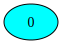

In [16]:
CMGDB.PlotMorseGraph(morse_graph, cmap=matplotlib.cm.cool)